# NGS data analysis in R
In this part of the workshop we will quickly overview a few useful tools that are available in `R`, which are very useful for NGS data analysis. Then we will use an MNase-seq data set to do some basic analyses.

### Running R in Jupyter notebook
To run R commands in a Jupyter notebook, you need to install the R kernel for Jupyter. From the terminal (not RStudio or R GUI), launch R (type R and press <return>), and run the following commands:
```r
install.packages('devtools')
devtools::install_github('IRkernel/IRkernel')
# If using R 3.5, run
IRkernel::installspec(name = 'ir35', displayname = 'R 3.5')
# otherwise, change 3.5 to the version of R that is installed on your computer
```

### IRanges
The `IRanges` package provides an efficient infrastructure for manipulating intervals/ranges of integers. This package is available on Bioconductor:  
https://bioconductor.org/packages/release/bioc/html/IRanges.html

To install this package, start R and enter:

```r
if (!requireNamespace("BiocManager", quietly = TRUE))  
    install.packages("BiocManager")  
BiocManager::install("IRanges", version = "3.8")
```

In [1]:
# Load the IRanges package 
suppressMessages(library(IRanges))

`IRanges` are simple intervals that are defined by three parameters:
- start
- end
- width

To create an `IRanges` object, specify at least two of the above three parameters.

In [2]:
# Construct IRanges by specifying the start and width of each interval
ir = IRanges(start=c( 1,  5,  8, 25),
             width=c(10, 11, 13,  6))
ir

IRanges object with 4 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         1        10        10
  [2]         5        15        11
  [3]         8        20        13
  [4]        25        30         6

In [3]:
# Construct IRanges by specifying the start and the end of each interval
ir2 = IRanges(start=1:3, end=10)
ir2

IRanges object with 3 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         1        10        10
  [2]         2        10         9
  [3]         3        10         8

In [4]:
ir3 = IRanges(end=10, width=10:8)
ir3

IRanges object with 3 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         1        10        10
  [2]         2        10         9
  [3]         3        10         8

The properties of the intervals can be accessed using the `start()`, `end()` and `width()` methods.

In [5]:
# Get the start positions of all ranges
start(ir)

[1]  1  5  8 25

In [6]:
# Get the end positions of all ranges
end(ir)

[1] 10 15 20 30

In [7]:
# Get the widths of all ranges
width(ir)

[1] 10 11 13  6

In order to illustrate range operations, we’ll create a function to plot ranges.

In [8]:
plotRanges = function(x, xlim=x, main=deparse(substitute(x)), col="gray", sep=0.5, ...){
  height = 1
  if (is(xlim, "IntegerRanges")) 
    xlim = c(min(start(xlim)), max(end(xlim)))
  bins = disjointBins(IRanges(start(x), end(x) + 1))
  plot.new()
  plot.window(xlim, c(0, max(bins)*(height + sep)))
  ybottom = bins * (sep + height) - height
  rect(start(x)-0.5, ybottom, end(x)+0.5, ybottom + height, col=col, ...)
  title(main)
  axis(1)
}
    
# Change plot size to 4in x 2.5in
library(repr)
options(repr.plot.width=4, repr.plot.height=2.5)

IRanges object with 4 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         1        10        10
  [2]         5        15        11
  [3]         8        20        13
  [4]        25        30         6

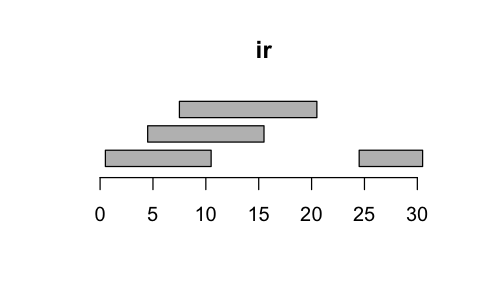

In [9]:
# Now we can visualize the intervals corresponding to the IRanges
ir
plotRanges(ir)

### Operations with IRanges
There are many operations that can be applied to IRanges (see https://bioconductor.org/packages/release/bioc/vignettes/IRanges/inst/doc/IRangesOverview.pdf). The operations that are most useful for us are explained below.

In [10]:
# Counting overlapping ranges 
# (i.e. computing the coverage/occupancy of all ranges)

# The function coverage() counts the number of ranges over each position.
cov = coverage(ir)
cov

integer-Rle of length 30 with 7 runs
  Lengths: 4 3 3 5 5 4 6
  Values : 1 2 3 2 1 0 1

**Note:** The coverage is stored using the run-length encoding (Rle) format.  
One can convert this into an ordinary R vector using the `as.vector()` function.

In [11]:
as.vector(cov)

[1] 1 1 1 1 2 2 2 3 3 3 2 2 2 2 2 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1

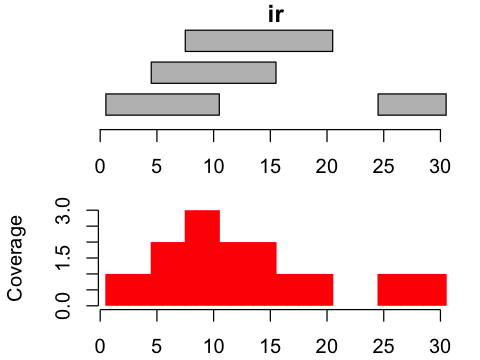

In [12]:
# Plot the result of coverage()
options(repr.plot.width=4, repr.plot.height=3)
par(mfrow=c(2,1), mar=c(2, 4, 1, 1) + 0.1)
plotRanges(ir)
cov = as.vector(cov)
plot(seq(1:length(cov)), cov, type='h', col="red", lwd=10, lend=1,
     xlab="Position", ylab="Coverage", bty="n")

In [13]:
# Resizing

# Example IRanges
ir = IRanges(start=c(1, 5, 9), width=3)
ir

IRanges object with 3 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         1         3         3
  [2]         5         7         3
  [3]         9        11         3

In [14]:
# We can resize the ranges to have a new width, by keeping fixed either the start, 
# end, or center of the original intervals

# Resize to width 1, keeping the left end fixed
resize(ir, width=1, fix="start")

IRanges object with 3 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         1         1         1
  [2]         5         5         1
  [3]         9         9         1

In [15]:
# Resize to width 1, keeping the right end fixed
resize(ir, width=1, fix="end")

IRanges object with 3 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         3         3         1
  [2]         7         7         1
  [3]        11        11         1

In [16]:
# Resize to width 1, keeping the center fixed
resize(ir, width=1, fix="center")

IRanges object with 3 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]         2         2         1
  [2]         6         6         1
  [3]        10        10         1

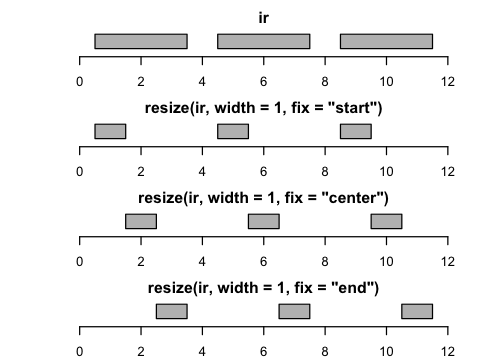

In [17]:
# Plot the results of the resize operations
options(repr.plot.width=4, repr.plot.height=3)
par(mfrow=c(4,1), mar=c(2, 4, 2, 1) + 0.1)
plotRanges(ir, xlim=c(0,12))
plotRanges(resize(ir, width=1, fix="start"), xlim=c(0,12))
plotRanges(resize(ir, width=1, fix="center"), xlim=c(0,12))
plotRanges(resize(ir, width=1, fix="end"), xlim=c(0,12))

More info on `IRanges`:
https://bioconductor.org/packages/release/bioc/vignettes/IRanges/inst/doc/IRangesOverview.pdf

### GRanges
The `GenomicRanges` package provides the `GRanges` class that allows manipulation of genomic ranges.  
https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html

To install this package, run the following commands in R:

```r
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("GenomicRanges", version = "3.8")
```

In [18]:
# Load the GenomicRanges package
suppressMessages(library(GenomicRanges))

The `GRanges` class represents a collection of genomic ranges. Each genomic range is characterized by a chromosome name, a start and end location, and a strand. This class can be used to store the location of genomic features such as genes, transcripts, and binding sites. Genomic ranges can be created by using the `GRanges` constructor.

In [19]:
# Construct a GRanges object
gr = GRanges(
    seqnames = c("chr1", "chr2", "chr3"),
    ranges = IRanges(start = c(1, 3, 5), width = 5),
    strand = c("+", "-", "+"))
gr

GRanges object with 3 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1       1-5      +
  [2]     chr2       3-7      -
  [3]     chr3       5-9      +
  -------
  seqinfo: 3 sequences from an unspecified genome; no seqlengths

In [20]:
# Occupancy of GRanges is also computed using the coverage() method
cov = coverage(gr)
cov

RleList of length 3
$chr1
integer-Rle of length 5 with 1 run
  Lengths: 5
  Values : 1

$chr2
integer-Rle of length 7 with 2 runs
  Lengths: 2 5
  Values : 0 1

$chr3
integer-Rle of length 9 with 2 runs
  Lengths: 4 5
  Values : 0 1


In [21]:
# Show coverage of chr3 as a normal vector
as.vector(cov$chr3)

[1] 0 0 0 0 1 1 1 1 1

In [22]:
# GRanges can also be resized
# Resize to width 1 and keep the center fixed
gr
resize(gr, width=1, fix="center")

GRanges object with 3 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1       1-5      +
  [2]     chr2       3-7      -
  [3]     chr3       5-9      +
  -------
  seqinfo: 3 sequences from an unspecified genome; no seqlengths

GRanges object with 3 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1         3      +
  [2]     chr2         5      -
  [3]     chr3         7      +
  -------
  seqinfo: 3 sequences from an unspecified genome; no seqlengths

In [23]:
# When we resize the GRanges and keep the "start" fixed 
# we observe something interesting
gr
resize(gr, width=1, fix="start")

GRanges object with 3 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1       1-5      +
  [2]     chr2       3-7      -
  [3]     chr3       5-9      +
  -------
  seqinfo: 3 sequences from an unspecified genome; no seqlengths

GRanges object with 3 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1         1      +
  [2]     chr2         7      -
  [3]     chr3         5      +
  -------
  seqinfo: 3 sequences from an unspecified genome; no seqlengths

When resizing `GRanges`, fix="start" indicates that the 5' end of the interval will remain fixed (not necessarily the left end).

In [24]:
# Similarly, we can keep the 3' end fixed, by using the option fix="end"
gr
resize(gr, width=1, fix="end")

GRanges object with 3 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1       1-5      +
  [2]     chr2       3-7      -
  [3]     chr3       5-9      +
  -------
  seqinfo: 3 sequences from an unspecified genome; no seqlengths

GRanges object with 3 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1         5      +
  [2]     chr2         3      -
  [3]     chr3         9      +
  -------
  seqinfo: 3 sequences from an unspecified genome; no seqlengths

More info about `GRanges` can be found here: https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html

Next we will use `GRanges` to illustrate the typical steps in a basic analysis of MNase-seq data.

### MNase-seq data analysis
For this we will use a few extra R packages. To install the necessary R packages, run the following commands in R:
```r
# To install the required Bioconductor packages, run:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(
    c("genomation", "Gviz", "GenomicFeatures", "Rsamtools", "rtracklayer"))

# To install other packages used in this notebook, run:
install.packages("ggplot2")
install.packages("pryr")
install.packages("RMariaDB")
install.packages("caTools")
install.packages("colorRamps")
```

In [25]:
# Load the necessary packages
suppressMessages({
    library(genomation)
    library(Gviz)
    library(GenomicFeatures)
    library(Rsamtools)
    library(rtracklayer)
    library(ggplot2)
    library(pryr)
    library(caTools)
    library(colorRamps)
})

First, we need to read the aligned reads from a `bam` file.  
If the alignment of all reads was not done already in the previous part of the workshop, then copy the bam file `SRR3649298.sorted.bam` from the `data_backup` folder to the `bam_files` folder, by running the following command:
```r
file.copy('data_backup/SRR3649298.sorted.bam', 'bam_files')
```

In [26]:
# file.copy('data_backup/SRR3649298.sorted.bam', 'bam_files')

In [27]:
# List all bam files from our bam folder
all_bam_files = list.files("bam_files/", pattern = ".bam$", full.names = TRUE)
print(all_bam_files)

[1] "bam_files//SRR3649298.sorted.bam" "bam_files//test.bam"             
[3] "bam_files//test.sorted.bam"      


In [28]:
# Load one of the bam files
bam_file = Rsamtools::BamFile('bam_files/SRR3649298.sorted.bam')

In [29]:
# There are many fields that are stored and can be imported from a bam file. These are:
scanBamWhat()

[1] "qname"       "flag"        "rname"       "strand"      "pos"        
 [6] "qwidth"      "mapq"        "cigar"       "mrnm"        "mpos"       
[11] "isize"       "seq"         "qual"        "groupid"     "mate_status"

For now, we will only need the following info:
   - qname - read (query) name
   - rname - reference (chromosome) name 
   - strand
   - pos   - start position of the read
   - isize - full length of the paired-end read

In [30]:
# Import selected fields from the bam file
fields_to_load = c("qname", "rname", "strand", "pos", "isize")
param = ScanBamParam(what = fields_to_load)
aln = scanBam(bam_file, param = param)

In [31]:
# Check the structure of the aln object
str(aln)

List of 1
 $ :List of 5
  ..$ qname : chr [1:20736288] "SRR3649298.4581098" "SRR3649298.4402766" "SRR3649298.8910767" "SRR3649298.6870098" ...
  ..$ rname : Factor w/ 17 levels "chrI","chrII",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ strand: Factor w/ 3 levels "+","-","*": 1 1 1 1 1 1 2 1 1 1 ...
  ..$ pos   : int [1:20736288] 2 4 4 6 6 7 11 12 13 13 ...
  ..$ isize : int [1:20736288] 61 59 57 57 57 75 -57 56 66 66 ...


In [32]:
# Let's subset the first element (all the information is in there)
aln = aln[[1]]

In [33]:
# Get the total number of reads
length(aln$qname)

[1] 20736288

There are about 20 million reads, corresponding to about 10 million pairs (paired-end reads).

In [34]:
# Construct GRanges from the paired-end reads
read_on_Watson_strand = (aln$strand == '+') & (aln$isize > 0)
reads = GRanges(seqnames = Rle(aln$rname[read_on_Watson_strand]),
                ranges = IRanges(start = aln$pos[read_on_Watson_strand],
                                 width = aln$isize[read_on_Watson_strand]),
                seqinfo = seqinfo(bam_file))
reads

GRanges object with 10340584 ranges and 0 metadata columns:
             seqnames        ranges strand
                <Rle>     <IRanges>  <Rle>
         [1]     chrI          2-62      *
         [2]     chrI          4-62      *
         [3]     chrI          4-60      *
         [4]     chrI          6-62      *
         [5]     chrI          6-62      *
         ...      ...           ...    ...
  [10340580]   chrXVI 947931-947997      *
  [10340581]   chrXVI 947969-948033      *
  [10340582]   chrXVI 947979-948062      *
  [10340583]   chrXVI 947989-948039      *
  [10340584]   chrXVI 948006-948060      *
  -------
  seqinfo: 17 sequences from an unspecified genome

In [35]:
# Check the size of memory that are occupied by aln and reads objects
pryr::object_size(aln)
pryr::object_size(reads)

1.33 GB

82.7 MB

The `aln` object occupies 1.3 GB of memory, while the `GRanges` occupy only 80 MB. To free some memory, the `aln` object can be removed now.

In [36]:
# To save some memory, you can remove aln from the memory now
rm(aln)

In [37]:
# Check the number of paired-end reads that were mapped to each chromosome
no_of_reads = table(seqnames(reads))
no_of_reads


   chrI   chrII  chrIII   chrIV   chrIX    chrM    chrV   chrVI  chrVII chrVIII 
 176486  619123  241879 1175642  349356    9790  449570  212569  836807  445682 
   chrX   chrXI  chrXII chrXIII  chrXIV   chrXV  chrXVI 
 590686  512675 1839424  724905  585225  843454  727311 

In [38]:
# Get the chromosome lengths
chr_lengths = seqlengths(seqinfo(bam_file))
chr_lengths

chrI   chrII  chrIII   chrIV   chrIX    chrM    chrV   chrVI  chrVII chrVIII 
 230218  813184  316620 1531933  439888   85779  576874  270161 1090940  562643 
   chrX   chrXI  chrXII chrXIII  chrXIV   chrXV  chrXVI 
 745751  666816 1078177  924431  784333 1091291  948066

In [39]:
# Compute the sequencing depth (number of reads / chromosome)
no_of_reads_per_bp = no_of_reads / chr_lengths
no_of_reads_per_bp


     chrI     chrII    chrIII     chrIV     chrIX      chrM      chrV     chrVI 
0.7666038 0.7613566 0.7639410 0.7674239 0.7941931 0.1141305 0.7793210 0.7868234 
   chrVII   chrVIII      chrX     chrXI    chrXII   chrXIII    chrXIV     chrXV 
0.7670514 0.7921222 0.7920687 0.7688403 1.7060501 0.7841634 0.7461435 0.7728956 
   chrXVI 
0.7671523 

There's a slight variability in the sequencing depth per chromosome, and this is why I prefer to normalize the coverage profiles for each chromosome separately (more about this later).  

Chromosome 12 (chrXII) has a much higher sequencing depth though, because of the rDNA region, which we will mask later.

The mitochondrial DNA (chrM) has a much lower sequencing depth, but we don't care about chrM, which we will discard from the analysis anyway. 


In [40]:
# The name of all chromosomes can be obtained using seqlevels()
seqlevels(reads)

[1] "chrI"    "chrII"   "chrIII"  "chrIV"   "chrIX"   "chrM"    "chrV"   
 [8] "chrVI"   "chrVII"  "chrVIII" "chrX"    "chrXI"   "chrXII"  "chrXIII"
[15] "chrXIV"  "chrXV"   "chrXVI"

In [41]:
# Remove chrM
reads = dropSeqlevels(reads, "chrM", pruning.mode="coarse")
seqlevels(reads)

[1] "chrI"    "chrII"   "chrIII"  "chrIV"   "chrIX"   "chrV"    "chrVI"  
 [8] "chrVII"  "chrVIII" "chrX"    "chrXI"   "chrXII"  "chrXIII" "chrXIV" 
[15] "chrXV"   "chrXVI"

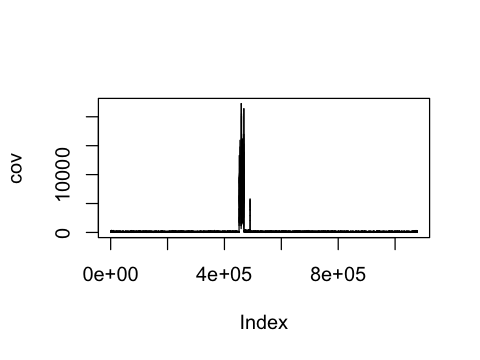

In [42]:
# Check the problem with chrXII

# Compute the coverage on chrXII
cov = coverage(reads)$chrXII

plot(cov, type='l')

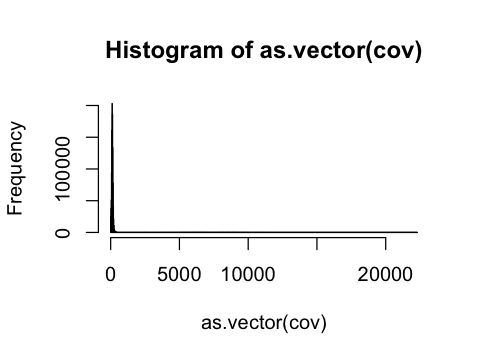

In [43]:
hist(as.vector(cov), nclass = 1000)

In [44]:
# Get a few quantiles for the coverage of chrXII
quantile(cov, probs = c(0.95, 0.96, 0.97, 0.98, 0.99))

95%  96%  97%  98%  99% 
 212  224  249  330 6772

In [45]:
# Let's see which regions have a coverage higher than 1000
slice(cov, lower=1000, rangesOnly=TRUE)

IRanges object with 4 ranges and 0 metadata columns:
          start       end     width
      <integer> <integer> <integer>
  [1]    451434    458717      7284
  [2]    458727    467854      9128
  [3]    467864    468929      1066
  [4]    489941    490421       481

In [46]:
# Create a GRanges object that contains all the problematic regions
# Discard the reads from the rDNA region
bad_regions = GRanges(seqnames = "chrXII",
                      ranges = IRanges(start = c(451000, 489000),
                                       end   = c(469000, 491000)))
bad_read_ind = overlapsAny(reads, bad_regions, ignore.strand=TRUE)
reads = reads[!bad_read_ind]

In [47]:
# Check the number of paired-end reads that were mapped to each chromosome,
# after removing the rDNA reads
no_of_reads = table(seqnames(reads))
chr_lengths = chr_lengths[seqlevels(reads)]
no_of_reads_per_bp = no_of_reads / chr_lengths
no_of_reads_per_bp


     chrI     chrII    chrIII     chrIV     chrIX      chrV     chrVI    chrVII 
0.7666038 0.7613566 0.7639410 0.7674239 0.7941931 0.7793210 0.7868234 0.7670514 
  chrVIII      chrX     chrXI    chrXII   chrXIII    chrXIV     chrXV    chrXVI 
0.7921222 0.7920687 0.7688403 0.7760711 0.7841634 0.7461435 0.7728956 0.7671523 

After removing the reads from the mitochondrial DNA and the problematic regions of `chrXII`, the sequencing depth became much more even (between 0.746 and 0.794 reads per bp).

In [48]:
# Save the sequencing depth to a csv file
dir.create("results")
write.csv(data.frame(Chrom = names(no_of_reads_per_bp), 
                     Reads_per_bp = as.vector(no_of_reads_per_bp)),
          file = "results/Sequencing_depth.SRR3649298.csv",
          row.names = FALSE)

Next, we'll check the fragment length distribution.

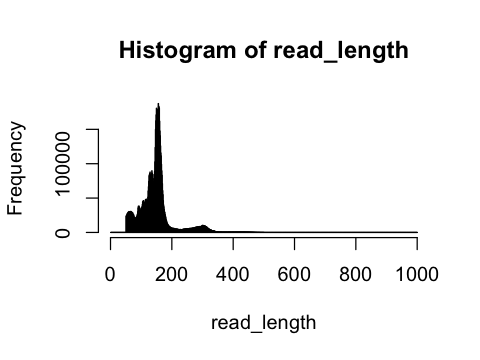

In [49]:
# Get read lengths. This is done easily using the width accessor (method) of GRanges 
read_length = width(reads)

# Plot a histogram of read lengths
h = hist(read_length, breaks = seq(from = 0.5, to = 1000.5, by = 1), plot = TRUE)

This plot shows the number of reads that have a given length. Since different samples have different total numbers of reads, it is more convenient to plot the percentage of reads for each length. We'll do this using `ggplot` to create a nicer figure.

Warning message:
"Removed 450 rows containing missing values (geom_path)."

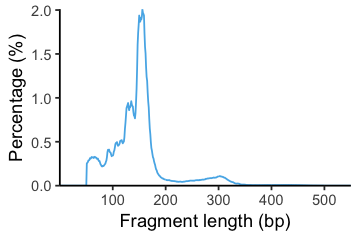

In [50]:
options(repr.plot.width=3, repr.plot.height=2)
df = data.frame(frag_length = h$mids, percentage_of_reads = 100*h$density)
p = ggplot(df, aes(x = frag_length, y = percentage_of_reads)) + 
  geom_line(colour="#56B4E9") +
  scale_x_continuous(limits = c(0, 550), expand = c(0, 0), 
                     breaks = seq(100, 500, 100)) +
  scale_y_continuous(expand = c(0, 0)) +
  theme_classic() +
  xlab("Fragment length (bp)") + 
  ylab("Percentage (%)")
p

In [51]:
# Save the histogram to a pdf file
ggsave(filename = "results/Length_histogram.SRR3649298.pdf", 
       plot = p, width = 4, height = 3, units = "in")

Warning message:
"Removed 450 rows containing missing values (geom_path)."

In [52]:
# Save the histogram to a csv file
write.csv(data.frame(Length = h$mids, Percentage = 100*h$density), 
          file = "results/Length_histogram.SRR3649298.csv", 
          row.names = FALSE)

Next, we will select the nucleosomal reads, with the length close to 150 bp (e.g. reads with the length between 120 bp and 180 bp), and we will analyze the distribution of the corresponding nucleosomes.

In [53]:
# Size selection
Lmin = 120
Lmax = 180
size_filter = ((read_length >= Lmin) & (read_length <= Lmax))
reads.120_180 = reads[size_filter]

In [54]:
# Compute the raw coverage of these reads
raw_occ = coverage(reads.120_180)

# Compute the average occupancy for each chromosome
chr_label = seqlevels(raw_occ)
for(chr in chr_label){
    cat(sprintf("Avg. occ. for %s is %0.3f\n", chr, mean(raw_occ[[chr]])))
}

Avg. occ. for chrI is 74.807
Avg. occ. for chrII is 72.880
Avg. occ. for chrIII is 73.801
Avg. occ. for chrIV is 73.131
Avg. occ. for chrIX is 77.191
Avg. occ. for chrV is 74.191
Avg. occ. for chrVI is 76.503
Avg. occ. for chrVII is 72.982
Avg. occ. for chrVIII is 75.884
Avg. occ. for chrX is 76.808
Avg. occ. for chrXI is 73.616
Avg. occ. for chrXII is 74.203
Avg. occ. for chrXIII is 75.107
Avg. occ. for chrXIV is 71.542
Avg. occ. for chrXV is 73.935
Avg. occ. for chrXVI is 73.067


In [55]:
# Get the normalization factor, 1 / avg(occ), for each chromosome
occ_norm_factor = list()
for(chr in chr_label){
    occ_norm_factor[[chr]] = 1/mean(raw_occ[[chr]])
}

In [56]:
# Compute the normalized occupancy (relative to chromosome average)
norm_occ = coverage(reads.120_180, weight = occ_norm_factor)

In [57]:
# Check the averages of the normalized occupancy for each chromosome
for(chr in chr_label){
    cat(sprintf("Avg. occ. for %s is %0.3f\n", chr, mean(norm_occ[[chr]])))
}

Avg. occ. for chrI is 1.000
Avg. occ. for chrII is 1.000
Avg. occ. for chrIII is 1.000
Avg. occ. for chrIV is 1.000
Avg. occ. for chrIX is 1.000
Avg. occ. for chrV is 1.000
Avg. occ. for chrVI is 1.000
Avg. occ. for chrVII is 1.000
Avg. occ. for chrVIII is 1.000
Avg. occ. for chrX is 1.000
Avg. occ. for chrXI is 1.000
Avg. occ. for chrXII is 1.000
Avg. occ. for chrXIII is 1.000
Avg. occ. for chrXIV is 1.000
Avg. occ. for chrXV is 1.000
Avg. occ. for chrXVI is 1.000


Similarly, we can compute the genome-wide distribution of the nucleosome dyads (centers of DNA fragments).

In [58]:
# Get the centers of all reads
dyad_pos.120_180 = resize(reads.120_180, width=1, fix="center")
head(dyad_pos.120_180)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chrI       124      *
  [2]     chrI       179      *
  [3]     chrI       161      *
  [4]     chrI       197      *
  [5]     chrI       186      *
  [6]     chrI       196      *
  -------
  seqinfo: 16 sequences from an unspecified genome

In [59]:
# Stack all dyad positions to construct the raw distribution of dyads
raw_dyads = coverage(dyad_pos.120_180)

In [60]:
# Get the normalization factors for each chromosome
dyads_norm_factor = list()
for(chr in chr_label){
    dyads_norm_factor[[chr]] = 1/mean(raw_dyads[[chr]])
}

In [61]:
# Compute the normalized dyad distribution (relative to chromosome average)
norm_dyads = coverage(dyad_pos.120_180, weight = dyads_norm_factor)

In [62]:
# Check the averages of the normalized dyad distribution for each chromosome
for(chr in chr_label){
    cat(sprintf("Avg. dyad density for %s is %0.3f\n", chr, mean(norm_dyads[[chr]])))
}

Avg. dyad density for chrI is 1.000
Avg. dyad density for chrII is 1.000
Avg. dyad density for chrIII is 1.000
Avg. dyad density for chrIV is 1.000
Avg. dyad density for chrIX is 1.000
Avg. dyad density for chrV is 1.000
Avg. dyad density for chrVI is 1.000
Avg. dyad density for chrVII is 1.000
Avg. dyad density for chrVIII is 1.000
Avg. dyad density for chrX is 1.000
Avg. dyad density for chrXI is 1.000
Avg. dyad density for chrXII is 1.000
Avg. dyad density for chrXIII is 1.000
Avg. dyad density for chrXIV is 1.000
Avg. dyad density for chrXV is 1.000
Avg. dyad density for chrXVI is 1.000


In [63]:
# Save profiles to BigWig files
rtracklayer::export.bw(norm_occ, "results/Norm_occ.SRR3649298.120-180.bw")
rtracklayer::export.bw(norm_dyads, "results/Norm_dyads.SRR3649298.120-180.bw")

### Visualizations
Next we will visualize the nucleosome distribution in different ways. The BigWig files that we created can be loaded in the IGV browser (http://software.broadinstitute.org/software/igv/), but we can also visualize the data directly in R.

First, let's look at a single genomic locus. Let's look at the _ARG1_ gene (`chrXV:219,211-220,473`).

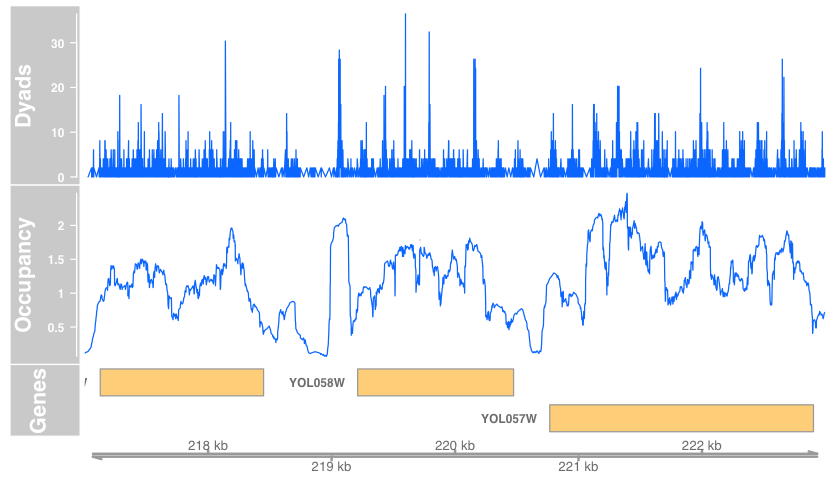

In [64]:
# Specify the range to plot (an interval from chrXV that includes ARG1 gene)
chr = "chrXV"
view_from = 217000
view_to = 223000

dyadsTrack = DataTrack(
    range = "results/Norm_dyads.SRR3649298.120-180.bw",
    type = "l",
    genome = "sacCer3",
    name = "Dyads"
)

occTrack = DataTrack(
    range = "results/Norm_occ.SRR3649298.120-180.bw",
    type = "l",
    genome = "sacCer3",
    name = "Occupancy"
)

# Get gene/transcript annotations from UCSC
# txdb = makeTxDbFromUCSC(genome="sacCer3", tablename = "sgdGene")

# To minimize the internet traffic, I saved the txdb object in TxDbFromUCSC.sqlite
# Get gene/transcript annotations directly from the local file
txdb = loadDb("data_backup/TxDbFromUCSC.sqlite")

# Generate a gene annotation track
genesTrack = GeneRegionTrack(txdb, name="Genes", showId=TRUE)

# Genomic coordinate track
coordTrack = GenomeAxisTrack()

options(repr.plot.width=7, repr.plot.height=4)
plotTracks(
    list(dyadsTrack, occTrack, genesTrack, coordTrack),
    chromosome = "chrXV", 
    from = view_from, to = view_to
)

In [65]:
# Save figure to a pdf file
pdf("results/Nuc_distribution.ARG1.pdf")
plotTracks(
    list(dyadsTrack, occTrack, genesTrack, coordTrack),
    chromosome = "chrXV", 
    from = view_from, to = view_to
)
dev.off()

pdf 
  2

We see that for these 3 genes, the gene bodies are covered by arrays of nucleosomes, and their promoters are depleted of nucleosomes. Let's see now if this is true for all yeast genes.

To check this we need to get first the gene annotations and their promoters. But we have already downloaded the gene/transcript annotations from UCSC into the `txdb` object.

In [66]:
# Get all gene annotations
all_genes = genes(txdb)
all_genes

GRanges object with 6534 ranges and 1 metadata column:
            seqnames        ranges strand |     gene_id
               <Rle>     <IRanges>  <Rle> | <character>
      Q0010     chrM     3952-4415      + |       Q0010
      Q0032     chrM   11667-11957      + |       Q0032
      Q0055     chrM   13818-26701      + |       Q0055
      Q0075     chrM   24156-25255      + |       Q0075
      Q0080     chrM   27666-27812      + |       Q0080
        ...      ...           ...    ... .         ...
    YPR200C   chrXVI 939279-939671      - |     YPR200C
    YPR201W   chrXVI 939922-941136      + |     YPR201W
    YPR202W   chrXVI 943032-944188      + |     YPR202W
  YPR204C-A   chrXVI 946856-947338      - |   YPR204C-A
    YPR204W   chrXVI 944603-947701      + |     YPR204W
  -------
  seqinfo: 17 sequences (1 circular) from sacCer3 genome

To get all transcripts, run
```r
all_transcripts = transcripts(txdb)
all_transcripts
```

In [67]:
# Get promoters and 5' ends of the genes using the promoters function.
prom = promoters(all_genes, upstream = 1000, downstream = 1001)
prom

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 25 out-of-bound ranges located on sequences
  chrI, chrII, chrIII, chrIV, chrV, chrVI, chrVII, chrVIII, chrIX, chrX,
  chrXI, chrXII, chrXIII, chrXIV, chrXV, and chrXVI. Note that ranges
  located on a sequence whose length is unknown (NA) or on a circular
  sequence are not considered out-of-bound (use seqlengths() and
  isCircular() to get the lengths and circularity flags of the underlying
  sequences). You can use trim() to trim these ranges. See
  ?`trim,GenomicRanges-method` for more information."

GRanges object with 6534 ranges and 1 metadata column:
            seqnames        ranges strand |     gene_id
               <Rle>     <IRanges>  <Rle> | <character>
      Q0010     chrM     2952-4952      + |       Q0010
      Q0032     chrM   10667-12667      + |       Q0032
      Q0055     chrM   12818-14818      + |       Q0055
      Q0075     chrM   23156-25156      + |       Q0075
      Q0080     chrM   26666-28666      + |       Q0080
        ...      ...           ...    ... .         ...
    YPR200C   chrXVI 938671-940671      - |     YPR200C
    YPR201W   chrXVI 938922-940922      + |     YPR201W
    YPR202W   chrXVI 942032-944032      + |     YPR202W
  YPR204C-A   chrXVI 946338-948338      - |   YPR204C-A
    YPR204W   chrXVI 943603-945603      + |     YPR204W
  -------
  seqinfo: 17 sequences (1 circular) from sacCer3 genome

We got a warning message that for some of the genes, the 2kb region near their start position may extend outside the chromosome ends.

In [68]:
# Get a few promoter examples that extend out of chromosome ends
head(prom[start(prom) < 0])

GRanges object with 6 ranges and 1 metadata column:
            seqnames    ranges strand |     gene_id
               <Rle> <IRanges>  <Rle> | <character>
    YAL069W     chrI -665-1335      + |     YAL069W
  YBL113W-A    chrII -354-1646      + |   YBL113W-A
  YEL077W-A     chrV -370-1630      + |   YEL077W-A
    YFL067W    chrVI -164-1836      + |     YFL067W
    YFL068W    chrVI -947-1053      + |     YFL068W
  YHL050W-A  chrVIII -189-1811      + |   YHL050W-A
  -------
  seqinfo: 17 sequences (1 circular) from sacCer3 genome

In [69]:
# Construct GRanges with the whole chromosomes and eliminate the 
# promoter regions that extend out-of-bounds
whole_chrom = as(seqinfo(txdb), "GRanges")
whole_chrom

GRanges object with 17 ranges and 0 metadata columns:
          seqnames    ranges strand
             <Rle> <IRanges>  <Rle>
     chrI     chrI  1-230218      *
    chrII    chrII  1-813184      *
   chrIII   chrIII  1-316620      *
    chrIV    chrIV 1-1531933      *
     chrV     chrV  1-576874      *
      ...      ...       ...    ...
  chrXIII  chrXIII  1-924431      *
   chrXIV   chrXIV  1-784333      *
    chrXV    chrXV 1-1091291      *
   chrXVI   chrXVI  1-948066      *
     chrM     chrM   1-85779      *
  -------
  seqinfo: 17 sequences (1 circular) from sacCer3 genome

In [70]:
# Eliminate out-of-bound promoter regions
prom = subsetByOverlaps(prom, whole_chrom, type="within")
prom

GRanges object with 6508 ranges and 1 metadata column:
          seqnames        ranges strand |     gene_id
             <Rle>     <IRanges>  <Rle> | <character>
    Q0010     chrM     2952-4952      + |       Q0010
    Q0032     chrM   10667-12667      + |       Q0032
    Q0055     chrM   12818-14818      + |       Q0055
    Q0075     chrM   23156-25156      + |       Q0075
    Q0080     chrM   26666-28666      + |       Q0080
      ...      ...           ...    ... .         ...
  YPR199C   chrXVI 938032-940032      - |     YPR199C
  YPR200C   chrXVI 938671-940671      - |     YPR200C
  YPR201W   chrXVI 938922-940922      + |     YPR201W
  YPR202W   chrXVI 942032-944032      + |     YPR202W
  YPR204W   chrXVI 943603-945603      + |     YPR204W
  -------
  seqinfo: 17 sequences (1 circular) from sacCer3 genome

In [71]:
# Remove mitochondrial DNA
prom = dropSeqlevels(prom, "chrM", pruning.mode="coarse")

# Remove promoters from the "bad regions" defined above
bad_prom_ind = overlapsAny(prom, bad_regions, ignore.strand=TRUE)
prom = prom[!bad_prom_ind]
prom

GRanges object with 6481 ranges and 1 metadata column:
          seqnames        ranges strand |     gene_id
             <Rle>     <IRanges>  <Rle> | <character>
  YAL001C     chrI 150166-152166      - |     YAL001C
  YAL002W     chrI 142707-144707      + |     YAL002W
  YAL003W     chrI 141174-143174      + |     YAL003W
  YAL004W     chrI 139760-141760      + |     YAL004W
  YAL005C     chrI 140431-142431      - |     YAL005C
      ...      ...           ...    ... .         ...
  YPR199C   chrXVI 938032-940032      - |     YPR199C
  YPR200C   chrXVI 938671-940671      - |     YPR200C
  YPR201W   chrXVI 938922-940922      + |     YPR201W
  YPR202W   chrXVI 942032-944032      + |     YPR202W
  YPR204W   chrXVI 943603-945603      + |     YPR204W
  -------
  seqinfo: 16 sequences from sacCer3 genome

Now we can use the `genomation` package to align all the gene promoters and to visualize the nucleosome distribution near the gene promoters. First we will create a function that aligns the coverage profile corresponding to multiple genomic ranges.

In [72]:
Align_GRanges = function(Profile, ReferenceGRanges)
{
  # Obtain Views for all GRanges that we wish to align
  myViews = Views(Profile, ReferenceGRanges)
  
  # Convert the RleViewsList (myViews) into a matrix
  AlignedProfilesList = lapply(myViews, function(gr) t(viewApply(gr, as.vector)))
  AlignedProfiles = do.call("rbind", AlignedProfilesList)
  
  ## Flip the rows corresponding to GRanges from the Crick strand
  CrickInd = which(as.character(strand(ReferenceGRanges)) == "-")
  AlignedProfiles[CrickInd,] = AlignedProfiles[CrickInd, ncol(AlignedProfiles):1]
      
  return(AlignedProfiles)
}

In [73]:
# Using this function we can align the dyad distribution of all promoters
dyad_matrix = Align_GRanges(norm_dyads, prom)

Warning message in RleViewsList(rleList = subject, rangesList = start):
"'rleList' was reordered so that its names match the names on
  'rangesList'"

Remember that nucleosomes cover the whole genome more or less uniformely, so we don't expect to see regions that have a nucleosome density much higher than the average density. We should check for regions that are outliers, and due to PCR/sequencing artifacts contain much more nucleosome reads.

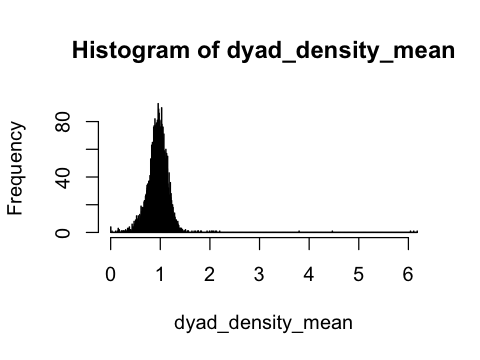

In [74]:
# Get the average nuc. density for each region
dyad_density_mean = rowMeans(dyad_matrix)

# Plot a histogram of the average nuc. density per region
options(repr.plot.width=4, repr.plot.height=3)
hist(dyad_density_mean, nclass=1000)

We see that the majority of regions have a nucleosome density between 0.5 and 1.5 relative to the genomic average. Let's eliminate the regions that have a nucleosome density more than 1.75 or less than 0.25.

In [75]:
bad_prom_regions = (dyad_density_mean > 1.75) | (dyad_density_mean < 0.25)
dyad_matrix = dyad_matrix[!bad_prom_regions, ]

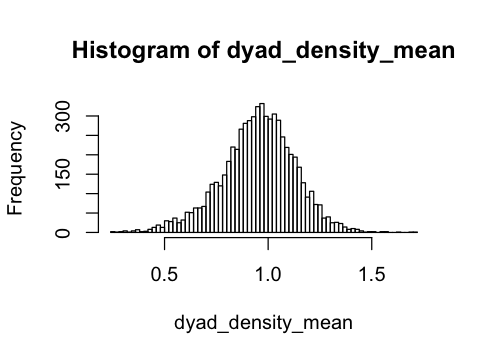

In [76]:
# Check again the dyad density per promoter, after the outliers have been removed
dyad_density_mean = rowMeans(dyad_matrix)
hist(dyad_density_mean, nclass=100)

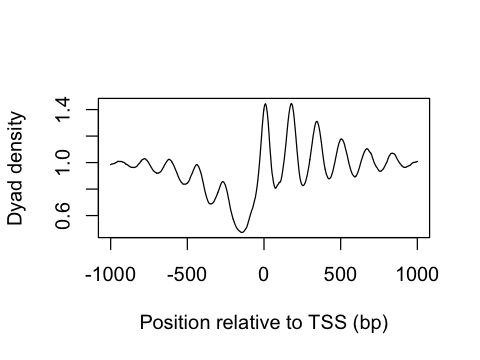

In [77]:
# Plot average dyad distribution
average_dyad_density = colMeans(dyad_matrix)
smoothed_dyad_density = runmean(average_dyad_density, k=51, alg="fast", endrule="mean")
plot(-1000:1000, smoothed_dyad_density, 'l',
     xlab = "Position relative to TSS (bp)", ylab = "Dyad density")

In [78]:
# Save a nicer version to a pdf file
pdf("results/Avg_dyads_at_TSS.SRR3649298.120-180.pdf", w=5, h=4)

par(mar=c(5,5,2,2))
plot(-1000:1000, smoothed_dyad_density, 
     axes=FALSE, typ='l', ann=FALSE, col = "blue",
     xlim=c(-1000, 1000), xaxs="i", yaxs="i", ylim = c(0, 1.05*max(smoothed_dyad_density)),
     panel.first = c(abline(v = seq(-500, 500, 500), col = "lightgray", lty = "dashed")))
box()

# x axis
par(tcl= -0.2)
axis(1, at=seq(-1000, 1000, by=100), labels=F, lwd=1, lwd.ticks=1)
par(tcl= -0.5)
axis(1, at=seq(-1000, 1000, by=500), labels=TRUE, lwd=0, lwd.ticks=1, cex.axis=1.25)

# y axis
axis(2, at=seq(0,5,0.2), cex.axis=1.25)
title(main="SRR3649298.120-180", font.main = 1, 
      xlab="Position relative to TSS (bp)", 
      ylab="Average dyad density", cex.lab=1.4)

dev.off()

pdf 
  2

Before we plot the heat map showing the nucleosome dyad distribution for all genes, let's smooth a little the nucleosome distribution.

In [79]:
smoothed_dyad_matrix = runmean(dyad_matrix, 21, alg="fast", endrule="mean")
smoothed_dyad_matrix = t(runmean(t(smoothed_dyad_matrix), 21, alg="fast", endrule="mean"))
smoothed_dyad_matrix[smoothed_dyad_matrix < 0] = 0

In [80]:
# Function for drawing the color bar for the heat map
image.scale = function(z, zlim, col = heat.colors(12),
                        breaks, horiz=TRUE, ylim=NULL, xlim=NULL, ...){
  if(!missing(breaks)){
    if(length(breaks) != (length(col)+1)){stop("Must have one more break than colors")}
  }
  poly = vector(mode="list", length(col))
  for(i in seq(poly)){
    poly[[i]] = c(breaks[i], breaks[i+1], breaks[i+1], breaks[i])
  }
  xaxt = ifelse(horiz, "s", "n")
  yaxt = ifelse(horiz, "n", "s")
  if(horiz){YLIM = c(0,1); XLIM = range(breaks)}
  if(!horiz){YLIM = range(breaks); XLIM = c(0,1)}
  if(missing(xlim)) xlim = XLIM
  if(missing(ylim)) ylim = YLIM
  plot(1, 1, t="n", ylim=ylim, xlim=xlim, xaxt=xaxt, yaxt=yaxt, xaxs="i", yaxs="i", ...)  
  for(i in seq(poly)){
    if(horiz){
      polygon(poly[[i]], c(0,0,1,1), col=col[i], border=NA)
    }
    if(!horiz){
      polygon(c(0,0,1,1), poly[[i]], col=col[i], border=NA)
    }
  }
}

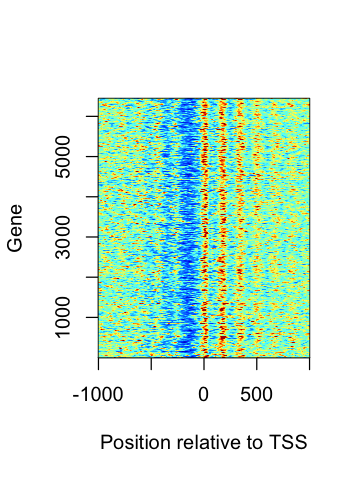

In [81]:
# Plot heat map
options(repr.plot.width=3, repr.plot.height=4)
image(-1000:1000, 1:nrow(smoothed_dyad_matrix), t(smoothed_dyad_matrix),
      col=matlab.like(101), xlab="Position relative to TSS", ylab="Gene", 
      breaks = c(seq(0, 2, length.out = 101), max(2.001, max(smoothed_dyad_matrix))),
      useRaster=TRUE)

In [82]:
# Save a nicer version to a pdf file
pdf("results/Heatmap_dyads_at_TSS.SRR3649298.120-180.pdf", w=6, h=6)

layout(matrix(c(1,2), ncol=2), widths=c(5,1))
par(mar=c(5,2,2,2))

image(-1000:1000, 1:nrow(smoothed_dyad_matrix), t(smoothed_dyad_matrix), col=matlab.like(101), 
      ylim=c(nrow(smoothed_dyad_matrix)+0.5,0.5), 
      breaks = c(seq(0, 2, length.out = 101), max(2 + 0.001, max(smoothed_dyad_matrix))),
      axes=FALSE, xlab="", ylab="", useRaster=TRUE)


par(tcl= -0.2)
axis(1, at=seq(-1000, 1000, by=100), labels=FALSE, lwd=1, lwd.ticks=1)
par(tcl= -0.5)
axis(1, at=seq(-1000, 1000, by=500), labels=TRUE, lwd=0, lwd.ticks=1, cex.axis=1.25)
title(main="SRR3649298.120-180", 
      xlab="Position relative to TSS (bp)", 
      ylab="", cex.main=1.4, cex.lab=1.4)
abline(v = 0, untf = FALSE, col = "white", lty = "longdash", lwd = 3)
box()

#Add scale
par(mar=c(25,0,2,4))
image.scale(col = matlab.like(100), breaks = seq(0, 2, length.out = 101), horiz=FALSE, xlab="", yaxt="n")
axis(4, at=seq(0, 2, 0.5), las=2)
box()

dev.off()

pdf 
  2

### Other resources:
https://www.datacamp.com/courses/free-introduction-to-r  
https://github.com/MonashDataFluency/r-intro-2/blob/master/docs/r-intro-2.pdf  
https://monashbioinformaticsplatform.github.io/r-more/topics/sequences_and_features.html
https://bioconductor.org/packages/release/bioc/vignettes/GenomicFeatures/inst/doc/GenomicFeatures.pdf
https://bioconductor.org/packages/release/bioc/vignettes/genomation/inst/doc/GenomationManual.html

#### More advanced topics:  
Reproducible pipelines using Snakemake  
https://snakemake.readthedocs.io/en/stable/tutorial/basics.html  
https://molb7621.github.io/workshop/Classes/snakemake-tutorial.html